In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import math

In [2]:
def resize_to_resnet_imagenet(x):
    return np.array([cv2.resize(i, (224,224)) for i in x])

def hot_encode(y):
    return np.array([[1,0] if e == 0 else [0,1] for e in y])

def save(filename, data):
    with open(filename, "w") as file:
        for v in data.flatten():
            file.write(str(v) + "\n")

In [3]:
x_train_normal = np.load("../files/COVID/x_train_normal.npy")
x_train_inverter = np.load("../files/COVID/x_train_inverter.npy")
y_train = np.load("../files/COVID/y_train.npy")
x_validation_normal = np.load("../files/COVID/x_validation_normal.npy")
x_validation_inverter = np.load("../files/COVID/x_validation_inverter.npy")
y_validation = np.load("../files/COVID/y_validation.npy")

In [5]:
x_train_normal_resized = resize_to_resnet_imagenet(x_train_normal)
x_train_inverter_resized = resize_to_resnet_imagenet(x_train_inverter)
x_validation_normal_resized = resize_to_resnet_imagenet(x_validation_normal)
x_validation_inverter_resized = resize_to_resnet_imagenet(x_validation_inverter)

y_train_encoded = hot_encode(y_train)
y_validation_encoded = hot_encode(y_validation)

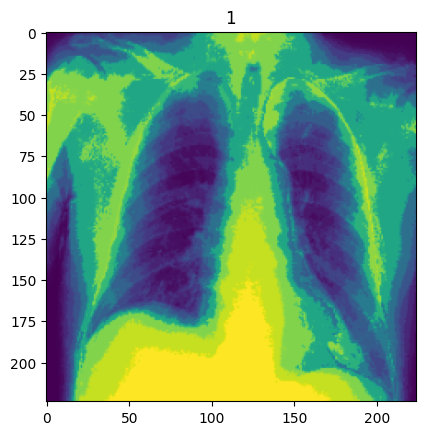

In [8]:
plt.title(y_train[0])
plt.imshow(x_train_normal_resized[0])

In [6]:
print(x_train_normal_resized.shape)
print(x_train_inverter_resized.shape)
print(x_validation_normal_resized.shape)
print(x_validation_inverter_resized.shape)

print(y_train_encoded.shape)
print(y_validation_encoded.shape)

(601, 224, 224)
(601, 224, 224)
(258, 224, 224)
(258, 224, 224)
(601, 2)
(258, 2)


In [15]:
save("../files/COVID/train_data", x_train_normal_resized)
save("../files/COVID/test_data", x_validation_normal_resized)
save("../files/COVID/train_labels", y_train_encoded)
save("../files/COVID/test_labels", y_validation_encoded)

In [13]:
def abs(x):
    print("x", x)
    print("(x >> 31)", (x >> 31))
    print("x+(x >> 31)", (x + (x >> 31)))
    return (x + (x >> 31)) ^ (x >> 31)

def relu(x):
    return (1 + (x >> 31) ^ (x >> 31)) * x

In [10]:
abs(-123123123123123)-123123123123123

71850

In [14]:
print(relu(1))
print(relu(125345))
print(relu(-10))
print(relu(-53405903))

1
125345
10
53405903


In [89]:
PRECISION = (1 << 26)
MAX_INT = (1 << 63)
MAX_RANGE = (1 << 30)

def overflow(val: int):
    if not -MAX_INT-1 <= val <= MAX_INT:
        print("Overflow! ", val, end="")
        val = (val + (MAX_INT + 1)) % (2 * (MAX_INT + 1)) - MAX_INT - 1
        print(", became", int(val))
    return int(val)

def fix_share(share: int):
    # if abs(share) > MAX_RANGE:
    #     print("share over range", share, "MAX", MAX_RANGE)
    return signed_modulo(share, MAX_RANGE)

# I'm looking for this property:
# x = x1 + x2 + x3 mod M = ((x1 mod M) + (x2 mod M) + (x3 mod M)) mod M
def signed_modulo(x: int, m: int):
    def pos(x):
        x = x + (x // (2*m-1))
        d = (x // (m))
        if d % 2 == 0:
            return x - d*m
        else:
            return -m+1+(x-d*m)
        
    if x == 0:
        return 0
    elif x > 0:
        return pos(x)
    else:
        return -pos(-x)


def fix_shares(share: tuple):
    return (fix_share(share[0]), fix_share(share[1]), fix_share(share[2]))

def to_share(x: int):
    x1 = random.randint(-10*PRECISION, 10*PRECISION)
    x2 = random.randint(-10*PRECISION, 10*PRECISION)
    x3 = x-x1-x2
    return (x1, x2, x3)

def reconstruct(shares: tuple):
    return signed_modulo(shares[0] + shares[1] + shares[2], MAX_RANGE)

def share_shift_right(shares: tuple, n: int):
    return (shares[0] >> n, shares[1] >> n, shares[2] >> n)

def share_sum(a: tuple, b: tuple):
    return (overflow(a[0]+b[0]), overflow(a[1]+b[1]), overflow(a[2]+b[2]))

def share_xor(a: tuple, b: tuple):
    return (a[0]^b[0], a[1]^b[1], a[2]^b[2])

# def share_abs(share: tuple):
#     #(x + (x >> 31)) ^ (x >> 31)
#     return share_xor(share_sum(share, share_shift_right(share, 31)), share_shift_right(share, 31))

def o_prod(a: int, b: int) -> int:
    return overflow(a*b)

def o_sum(a: int, b: int) -> int:
    return (overflow(a+b))

def share_mult(a: tuple, b: tuple, is_fixed = True):
    # print("a", a, "b", b)

    a0b0 = o_prod(a[0],b[0])
    # print("a0 * b0", a0b0)

    a0b1 = o_prod(a[0],b[1])
    # print("a0 * b1", a0b1)

    a1b0 = o_prod(a[1],b[0])
    # print("a1 * b0", a1b0)

    a1b1 = o_prod(a[1],b[1])
    # print("a1 * b1", a1b1)

    a1b2 = o_prod(a[1],b[2])
    # print("a1 * b2", a1b2)

    a2b1 = o_prod(a[2],b[1])
    # print("a2 * b1", a2b1)

    a2b0 = o_prod(a[2],b[0])
    # print("a2 * b0", a2b0)

    a2b2 = o_prod(a[2],b[2])
    # print("a2 * b2", a2b2)

    a0b2 = o_prod(a[0],b[2])
    # print("a0 * b2", a0b2)

    s1 = o_sum(o_sum(a0b0, a0b1), a1b0)
    s2 = o_sum(o_sum(a1b1, a1b2), a2b1)
    s3 = o_sum(o_sum(a2b0, a2b2), a0b2)

    if is_fixed:
        s1 = fix_share(s1) // PRECISION
        s2 = fix_share(s2) // PRECISION
        s3 = fix_share(s3) // PRECISION

    print("s1", s1)
    print("s2", s2)
    print("s3", s3)

    return fix_shares((s1, s2, s3))

def to_fixed(x: float):
    return int(x * PRECISION)

def to_float(n: int):
    return (1.0 * n) / PRECISION

def share_public_divide(share: tuple, denominator: int):
    return (overflow(share[0] // denominator), overflow(share[1] // denominator), overflow(share[2] // denominator))

def share_public_mult(share: tuple, factor: int):
    return (overflow(share[0] * factor), overflow(share[1] * factor), overflow(share[2] * factor))

def share_public_sum(share: tuple, term: int):
    return (overflow(share[0] + term), overflow(share[1] + term), overflow(share[2] + term))

def share_sigmoid(x: tuple):
    x2 = share_mult(x, x)
    x3 = share_mult(x2, x)

    return share_sum(
        share_sum(
            share_public_divide(x3, -48),
            share_public_divide(x, 4)
        ),
        to_share(to_fixed(0.5))
    )

def share_abs(x: tuple):
    x2 = share_mult(x, x)
    # x4 = share_public_divide(share_mult(x2, x2), PRECISION)

    # return share_sum(
    #     share_public_divide(
    #         share_sum(
    #             share_public_mult(x4, -1),
    #             share_public_mult(x2, 6)
    #         ),
    #         8
    #     ),
    #     to_share(to_fixed(3.0/8))
    # )
    return share_sum(
        share_public_divide(x2, 2),
        to_share(to_fixed(0.5))
    )

print(to_float(reconstruct(share_abs(to_share(123)))))
print(to_float(reconstruct(share_abs(to_share(-123)))))
print(share_abs((123, -123, 0)))

s1 986111989
s2 1830489470
s3 -2816601460
0.4999999701976776
s1 3511070302
s2 -1523777091
s3 -1987293213
0.4999999850988388
s1 -1
s2 0
s3 0
(-146804347, 112757090, 67601688)


[(-100, -5), (-99, -4), (-98, -3), (-97, -2), (-96, -1), (-95, 0), (-94, 1), (-93, 2), (-92, 3), (-91, 4), (-90, 5), (-89, 6), (-88, 7), (-87, 8), (-86, 9), (-85, -9), (-84, -8), (-83, -7), (-82, -6), (-81, -5), (-80, -4), (-79, -3), (-78, -2), (-77, -1), (-76, 0), (-75, 1), (-74, 2), (-73, 3), (-72, 4), (-71, 5), (-70, 6), (-69, 7), (-68, 8), (-67, 9), (-66, -9), (-65, -8), (-64, -7), (-63, -6), (-62, -5), (-61, -4), (-60, -3), (-59, -2), (-58, -1), (-57, 0), (-56, 1), (-55, 2), (-54, 3), (-53, 4), (-52, 5), (-51, 6), (-50, 7), (-49, 8), (-48, 9), (-47, -9), (-46, -8), (-45, -7), (-44, -6), (-43, -5), (-42, -4), (-41, -3), (-40, -2), (-39, -1), (-38, 0), (-37, 1), (-36, 2), (-35, 3), (-34, 4), (-33, 5), (-32, 6), (-31, 7), (-30, 8), (-29, 9), (-28, -9), (-27, -8), (-26, -7), (-25, -6), (-24, -5), (-23, -4), (-22, -3), (-21, -2), (-20, -1), (-19, 0), (-18, 1), (-17, 2), (-16, 3), (-15, 4), (-14, 5), (-13, 6), (-12, 7), (-11, 8), (-10, 9), (-9, -9), (-8, -8), (-7, -7), (-6, -6), (-5, -5

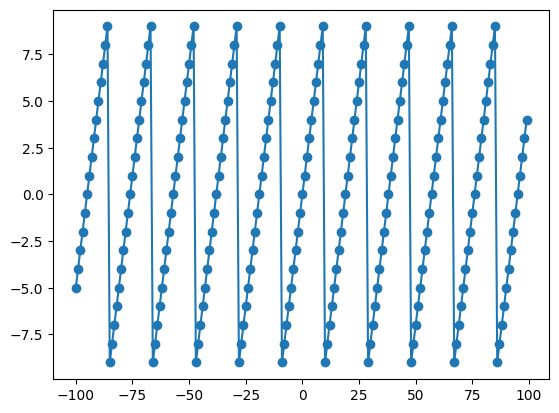

In [284]:
x=np.array(range(-100,100))
y=np.array([signed_modulo(xi, 10) for xi in x])

plt.plot(x,y,'-o')

print(list(zip(x,y)))

In [43]:
M = 100

x1 = np.random.randint(-1000, 1000)
x2 = np.random.randint(-1000, 1000)
x3 = np.random.randint(-1000, 1000)

x = signed_modulo(x1+x2+x3, M)
xm = signed_modulo(signed_modulo(x1, M)+signed_modulo(x2, M)+signed_modulo(x3,M), M)

print("x", x, "xm", xm)

x -56 xm -56


In [52]:
M = 100

x1 = np.random.randint(-1000, 1000)
x2 = np.random.randint(-1000, 1000)

x = signed_modulo(x1*x2, M)
xm = signed_modulo(signed_modulo(x1, M)*signed_modulo(x2, M), M)

print("x", x, "xm", xm)

x 43 xm 43


In [83]:
M = 100

x1 = np.random.randint(-1000, 1000)
a = np.random.randint(-10, 10)

x = signed_modulo(x1, M)

xdiv = x // a
xdivm = signed_modulo(signed_modulo(x1, M) // a, M)

print("x", x, "a", a, "xdiv", xdiv, "xdivm", xdivm)

x -3 a 9 xdiv -1 xdivm -1


In [468]:
print("Teste de multiplicação inteira")
# Test mult
for i in range(10):
    x = random.randint(-1000, 1000)
    y = random.randint(-1000, 1000)

    gold_mult = x*y
    mult = reconstruct(share_mult(to_share(x), to_share(y), is_fixed=False))

    print("Testing with x", x, "y", y, "gold", gold_mult, "mult", mult)
    assert gold_mult == mult

Teste de multiplicação inteira
s1 -6502818
s2 680257419
s3 -673754605
Testing with x -502 y -980 gold 491960 mult -4


AssertionError: 

In [21]:
# # Test shift right
# for i in range(10):
#     x = random.randint(-1000, 1000)
#     n = random.randint(0, 5)

#     gold_shift = x >> n
#     shares = to_share(x)
#     shift = reconstruct(share_shift_right(shares, n))

#     print("Testing with x", x, "shares", shares, "n", n, "gold", gold_shift, "shift", shift)
#     assert gold_shift == shift

In [87]:
# Test infinite product
print("Teste de produto infinito inteiro")
x1 = np.random.randint(-100,100)
x1s = to_share((x1))
for i in range(1000):
    x2 = np.random.randint(-5,5) # (-2, 2)
    if x2 == 0:
        x2 = 1
    x2s = to_share((x2))

    gold = x1 * x2

    if abs(gold) > MAX_RANGE:
        break
    result_s = share_mult(x1s, x2s, is_fixed=False)
    result = (reconstruct(result_s))

    print("Testing with x1", x1, "x2", x2, "gold", gold, "result", result)
    print("  result_s", result_s)
    assert abs(gold - result) < 1e-2

    x1 = gold
    x1s = result_s

Teste de produto infinito inteiro
s1 -202345898979412237
s2 -89746337394601351
s3 292092236374013622
Testing with x1 -17 x2 -2 gold 34 result 34
  result_s (334853607, -46783786, -288069787)
s1 -353277396087964282
s2 165057475702721385
s3 188219920385242931
Testing with x1 34 x2 1 gold 34 result 34
  result_s (-248361553, -748857034, 997218621)
s1 347101449705464096
s2 -159962348608423215
s3 -187139101097040813
Testing with x1 34 x2 2 gold 68 result 68
  result_s (-61214980, -447651584, 508866632)
s1 -8114069291893272
s2 190254272988374920
s3 -182140203696481852
Testing with x1 68 x2 -3 gold -204 result -204
  result_s (99800704, -608125430, 508324522)
s1 41384026274792142
s2 -450983798099017502
s3 409599771824225768
Testing with x1 -204 x2 -2 gold 408 result 408
  result_s (-90042391, -162164190, 252206989)
s1 -136757985097338821
s2 192576444013489676
s3 -55818458916152487
Testing with x1 408 x2 -4 gold -1632 result -1632
  result_s (-901286168, -287275889, -958923222)
s1 -39673975914

In [90]:
# Test infinite product
print("Teste de produto infinito ponto fixo")
x1 = 4*(np.random.random()-0.5)
x1s = to_share(to_fixed(x1))
for i in range(1000):
    x2 = 4*(np.random.random()-0.5) # (-2, 2)
    x2s = to_share(to_fixed(x2))

    gold = x1 * x2

    result_s = share_mult(x1s, x2s)
    result = to_float(reconstruct(result_s))

    print("Testing with x1", x1, "x2", x2, "gold", gold, "result", result)
    print("  result_s", result_s)
    assert abs(gold - result) < 1e-2

    x1 = gold
    x1s = result_s

Teste de produto infinito ponto fixo
s1 -8875599889
s2 546905610
s3 8446578770
Testing with x1 1.7623614372216352 x2 0.9967398272642312 gold 1.7566158345134348 result 1.7566158026456833
  result_s (-285665301, 546905610, -143355818)
s1 -1680018090
s2 171465741
s3 1435306524
Testing with x1 1.7566158345134348 x2 -0.6213355408498753 gold -1.0914478496028601 result -1.0914478451013565
  result_s (467465557, 171465741, -712177123)
s1 -9448692016
s2 7992226145
s3 1462059082
Testing with x1 -1.0914478496028601 x2 -0.07636222004881388 gold 0.08334538086317832 result 0.08334533870220184
  result_s (-858757428, -597708443, -685424565)
s1 10040875250
s2 2267865829
s3 -11884459809
Testing with x1 0.08334538086317832 x2 -0.1980872918870764 gold -0.016509660786483957 result 6.3222835958004
  result_s (-696542985, 120382182, 1000442073)


AssertionError: 

In [23]:
# Test sigmoid
print("Teste de sigmoide")
for i in range(1000):
    x = 2*(random.random()-0.5)

    gold = 1 / (1 + np.exp(-x))
    result = to_float(reconstruct(share_sigmoid(to_share(to_fixed(x)))))

    print("Testing with x", x, "gold", gold, "result", result)
    assert abs(gold - result) < 1e-2

Teste de sigmoide
Testing with x -0.3642330539330285 gold 0.40993525055888125 result 0.4099483788013458
Testing with x 0.6637228465118856 gold 0.6600961777729966 result 0.6598392426967621
Testing with x -0.9495777181782499 gold 0.27896975419181047 result 0.2804437130689621
Testing with x 0.018817923482512766 gold 0.5047043420485701 result 0.5047042816877365
Testing with x 0.33825952380653534 gold 0.5837676786058317 result 0.5837585180997849
Testing with x 0.9535076815291754 gold 0.7218200536881655 result 0.7203163057565689
Testing with x 0.4329497663833548 gold 0.606577824986451 result 85.93988001346588


AssertionError: 

In [88]:
w_size = 1000
samples = 10000

w = (np.random.random(w_size) - 0.5) * 2
gamma = np.sign(np.random.uniform(high=1, low=-1, size=(w_size, samples)))

random_sum = np.dot(w, gamma)
result = np.sum(np.abs(w))

possible_result = np.max(random_sum)


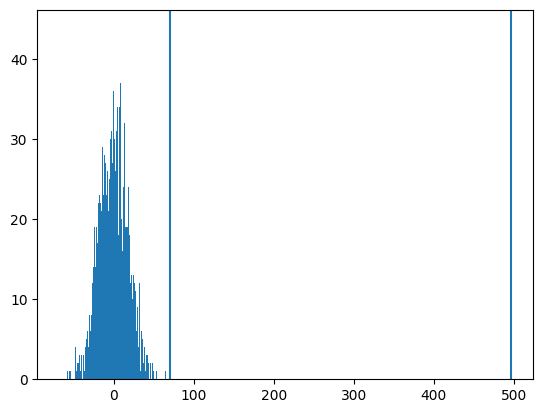

In [90]:
plt.hist(random_sum, samples//10)
plt.axvline(result)
plt.axvline(possible_result)

In [169]:
w_size = 10

w = (np.random.random(w_size) - 0.5) * 2
w_s = [to_share(to_fixed(wi)) for wi in w]

abs_w_s = [share_abs(wi) for wi in w_s]

sum_abs_w_s = (0,0,0)
for wi in abs_w_s:
    sum_abs_w_s = share_sum(sum_abs_w_s, wi)

gold = np.sum(np.abs(w))
result = to_float(reconstruct(sum_abs_w_s))

print("real sum abs wi =", gold)
print("reconstructed sum abs_approx wi =",result)

real sum abs wi = 5.1299626668346106
reconstructed sum abs_approx wi = 6.749755859375


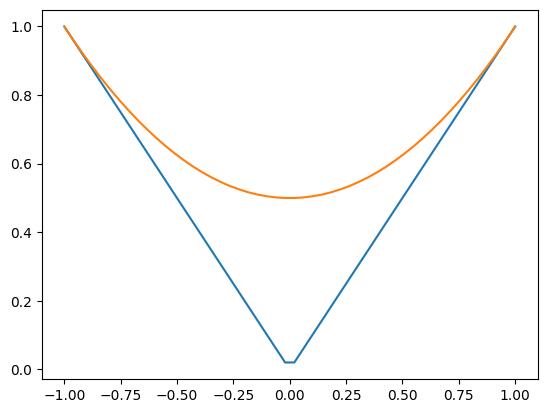

In [170]:
x = np.linspace(-1, 1)
y = np.abs(x)

xs = [to_share(to_fixed(e)) for e in x]
ys = [to_float(reconstruct(share_abs(e))) for e in xs]

plt.plot(x,y)
plt.plot(x,ys)

In [256]:
# Test sigmoid
x = 2*(random.random()-0.5)
xs = to_share(to_fixed(x))

for i in range(7):
    x = 1 / (1 + np.exp(-x))
    xs = share_sigmoid(xs)

print("gold =", x)
print("result =", to_float(reconstruct(xs)))


(700746328680451805, -499624522582429600, -198543976401303981)
(-5045088119377659941, -3742022707989782622, 8789061127389331691)
(5851627581988726560, -5765284438741975721, -84259945788275475)
(-4682585373340986037, 3185316409777517151, 1498685787020786308)
(4243069070176191771, 1307293354031610205, -5548379939321591160)
(-6493264848271262878, -2339630402595143631, 8834210581478854413)
(7921389353914923628, -2817312528212182344, -5102116339942960155)
(1558935056312728786, -2036747338649482327, 479105779904217517)
(280555727205220488, -994885609465888437, 716285486825507473)
(2241900619339892606, -7333629025452453610, 5093017075905744390)
(-2233781750949832308, -417049788765005704, 2652786057537023053)
(5727318680008063298, -5943552780288410607, 217521696071141845)
(-7075548461934125872, 2581421484343510533, 4496081253149897060)
(7043743572190106883, 4663532476701581978, 6740755381175137652)
gold = 0.6590488316542321
result = -84.67460398375988


/var/folders/lz/9gkg76096czgjnh7xhx3rg800000gn/T/ipykernel_82095/747150570.py:30: RuntimeWarning: overflow encountered in scalar add
  s1 = overflow(a[0]*b[0] + a[0]*b[1] + a[1]*b[0])
/var/folders/lz/9gkg76096czgjnh7xhx3rg800000gn/T/ipykernel_82095/747150570.py:32: RuntimeWarning: overflow encountered in scalar multiply
  s3 = overflow(a[2]*b[0] + a[2]*b[2] + a[0]*b[2])
/var/folders/lz/9gkg76096czgjnh7xhx3rg800000gn/T/ipykernel_82095/747150570.py:32: RuntimeWarning: overflow encountered in scalar add
  s3 = overflow(a[2]*b[0] + a[2]*b[2] + a[0]*b[2])
/var/folders/lz/9gkg76096czgjnh7xhx3rg800000gn/T/ipykernel_82095/747150570.py:30: RuntimeWarning: overflow encountered in scalar multiply
  s1 = overflow(a[0]*b[0] + a[0]*b[1] + a[1]*b[0])
/var/folders/lz/9gkg76096czgjnh7xhx3rg800000gn/T/ipykernel_82095/747150570.py:31: RuntimeWarning: overflow encountered in scalar multiply
  s2 = overflow(a[1]*b[1] + a[1]*b[2] + a[2]*b[1])
/var/folders/lz/9gkg76096czgjnh7xhx3rg800000gn/T/ipykernel_82095/